In [3]:
library(tidyverse)
library(plyr)
library(ggrepel)

In [4]:
code_dir <- getwd()
tool_dir <- unlist(strsplit(code_dir,"/"))
tool_dir <- head(tool_dir, length(tool_dir)-1)
tool_dir <- paste(c(tool_dir, "tools"), collapse="/")
source(file.path(tool_dir, "pl_functions.R"))
base_dir <- gsub("/plotting_codes", "", code_dir)
base_dir

[1] "/media/pipkin/ROCKET-PRO/CD8_DEV_SC"

In [5]:
exp_name <- "0_Acute-Chronic"
analysis_name <- c("0", "resampled") 

use.path <- file.path(base_dir, '9_Figures', exp_name, 
                      paste(analysis_name, collapse="_"),
                      'volcano_plots')
dir.create(use.path, showWarnings = FALSE, recursive=TRUE)
setwd(use.path)

In [6]:
label.file <- '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/2_scVelo/0_scVelo_out_resampled/pt_ordered_cluster_avg.csv'
label.df <- read_csv(label.file)

Parsed with column specification:
cols(
  louvain = col_double(),
  initial_size_spliced = col_double(),
  initial_size_unspliced = col_double(),
  initial_size = col_double(),
  n_counts = col_double(),
  dpt_pseudotime = col_double(),
  velocity_self_transition = col_double(),
  root_cells = col_double(),
  end_points = col_double(),
  velocity_pseudotime = col_double(),
  louvain_new_label = col_character()
)



## 0. All cells: cluster v.s. cluster

In [15]:
de.dir <- '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/1_Scanpy/0_Scanpy_out_resampled/2_DE/Cluster_vs_Cluster'

Parsed with column specification:
cols(
  gene_names = col_character(),
  `3` = col_double(),
  `6` = col_double(),
  wilcoxon_logfc = col_double(),
  wilcoxon_padj = col_double(),
  wilcoxon_score = col_double(),
  `t-test_logfc` = col_double(),
  `t-test_padj` = col_double(),
  `t-test_score` = col_double(),
  `t-test_overestim_var_logfc` = col_double(),
  `t-test_overestim_var_padj` = col_double(),
  `t-test_overestim_var_score` = col_double()
)

The following `from` values were not present in `x`: yes_FALSE_G2, yes_TRUE_G1, yes_TRUE_G2



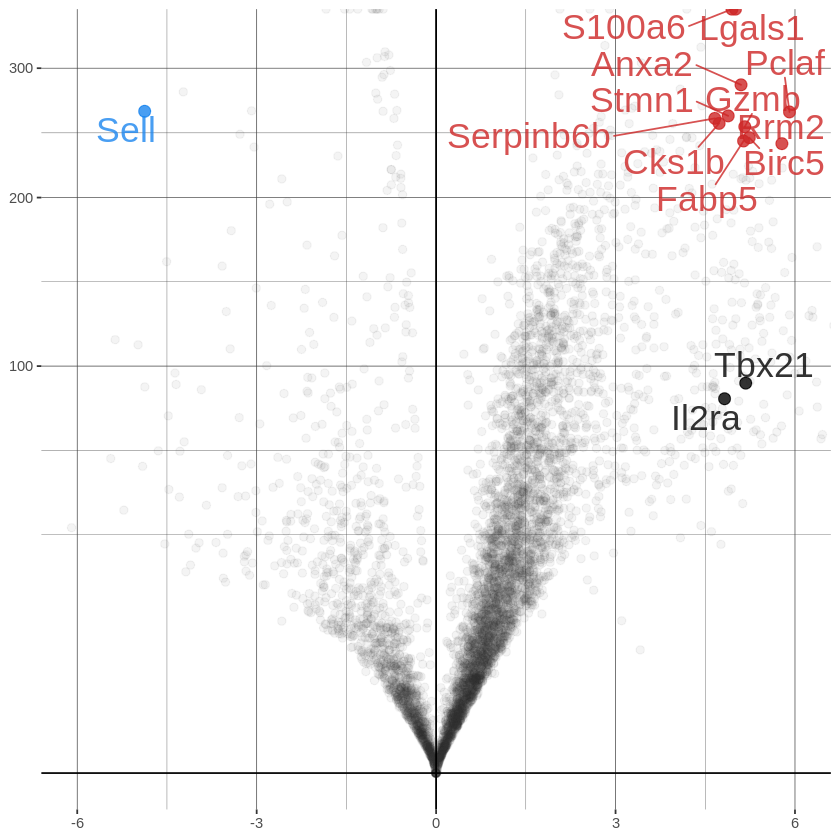

In [21]:
cp <- c("P2", "P0")
cp_oldnames <- cvt_names(cp, label.df$louvain_new_label, label.df$louvain)
cp_oldnames <- as.character(cp_oldnames)

###----- Setup
outname.base <- paste("All", cp[1], "vs", cp[2], sep="_")
use.genes <- c("Tbx21", "Il2ra", "Batf3")
log2fc.c <- 4.5
nlog10p.c <- 225

###----- Plot
# Read input
louvain.de.file <- paste(cp_oldnames[1], "vs", cp_oldnames[2], "differential.csv", sep="_")
louvain.de.file <- file.path(de.dir, file.path(cp_oldnames[1], louvain.de.file))
de.df <- read_csv(louvain.de.file)
# Filter out low expression & convert df for plotting
de.df <- de.df %>% 
  mutate(max_expr = pmax(pull(de.df, cp_oldnames[1]), pull(de.df, cp_oldnames[2]))) %>% filter(max_expr > 0.15) %>%
  drop_na() %>% select(one_of('gene_names', 't-test_logfc', 't-test_padj'))
colnames(de.df) <- c("gene_name", "log2fc", "padj")
de.df$nlog10pval <- -log10(de.df$padj)
# Plot
vol_plot <- volcano_plot(de.df, use.genes , log2fc.c, nlog10p.c) # With label
ggsave(paste(outname.base, ".png", sep=""), vol_plot, device='png', width=10, height=10, units='cm')
vol_plot
vol_plot <- vol_plot + theme(axis.text.x=element_blank(), axis.text.y=element_blank()) # Without label
ggsave(paste(outname.base, "_nolabel.png", sep=""), vol_plot, device='png', width=10, height=10, units='cm')

Parsed with column specification:
cols(
  gene_names = col_character(),
  `6` = col_double(),
  `7` = col_double(),
  wilcoxon_logfc = col_double(),
  wilcoxon_padj = col_double(),
  wilcoxon_score = col_double(),
  `t-test_logfc` = col_double(),
  `t-test_padj` = col_double(),
  `t-test_score` = col_double(),
  `t-test_overestim_var_logfc` = col_double(),
  `t-test_overestim_var_padj` = col_double(),
  `t-test_overestim_var_score` = col_double()
)

The following `from` values were not present in `x`: yes_FALSE_G1, yes_TRUE_G1, yes_TRUE_G2



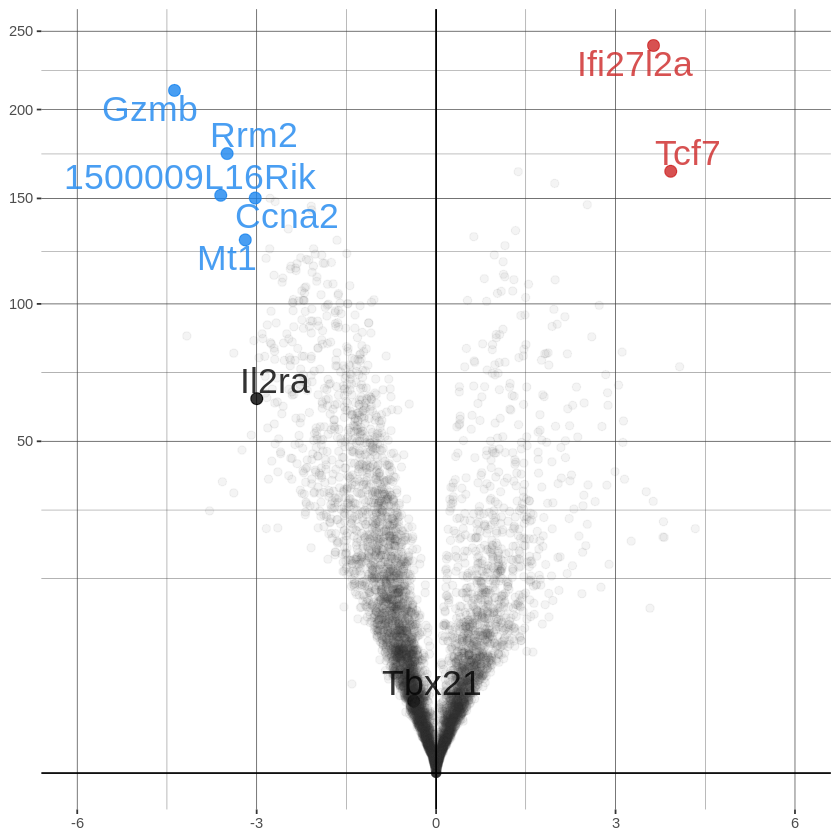

In [25]:
cp <- c("P7", "P2")
cp_oldnames <- cvt_names(cp, label.df$louvain_new_label, label.df$louvain)
cp_oldnames <- as.character(cp_oldnames)

###----- Setup
outname.base <- paste("All", cp[1], "vs", cp[2], sep="_")
use.genes <- c("Tbx21", "Il2ra", "Batf3")
log2fc.c <- 3
nlog10p.c <- 100

###----- Plot
# Read input
louvain.de.file <- paste(cp_oldnames[1], "vs", cp_oldnames[2], "differential.csv", sep="_")
louvain.de.file <- file.path(de.dir, file.path(cp_oldnames[1], louvain.de.file))
de.df <- read_csv(louvain.de.file)
# Filter out low expression & convert df for plotting
de.df <- de.df %>% 
  mutate(max_expr = pmax(pull(de.df, cp_oldnames[1]), pull(de.df, cp_oldnames[2]))) %>% filter(max_expr > 0.15) %>%
  drop_na() %>% select(one_of('gene_names', 't-test_logfc', 't-test_padj'))
colnames(de.df) <- c("gene_name", "log2fc", "padj")
de.df$nlog10pval <- -log10(de.df$padj)
# Plot
vol_plot <- volcano_plot(de.df, use.genes , log2fc.c, nlog10p.c) # With label
ggsave(paste(outname.base, ".png", sep=""), vol_plot, device='png', width=10, height=10, units='cm')
vol_plot
vol_plot <- vol_plot + theme(axis.text.x=element_blank(), axis.text.y=element_blank()) # Without label
ggsave(paste(outname.base, "_nolabel.png", sep=""), vol_plot, device='png', width=10, height=10, units='cm')

Parsed with column specification:
cols(
  gene_names = col_character(),
  `2` = col_double(),
  `6` = col_double(),
  wilcoxon_logfc = col_double(),
  wilcoxon_padj = col_double(),
  wilcoxon_score = col_double(),
  `t-test_logfc` = col_double(),
  `t-test_padj` = col_double(),
  `t-test_score` = col_double(),
  `t-test_overestim_var_logfc` = col_double(),
  `t-test_overestim_var_padj` = col_double(),
  `t-test_overestim_var_score` = col_double()
)

The following `from` values were not present in `x`: yes_TRUE_G1, yes_TRUE_G2



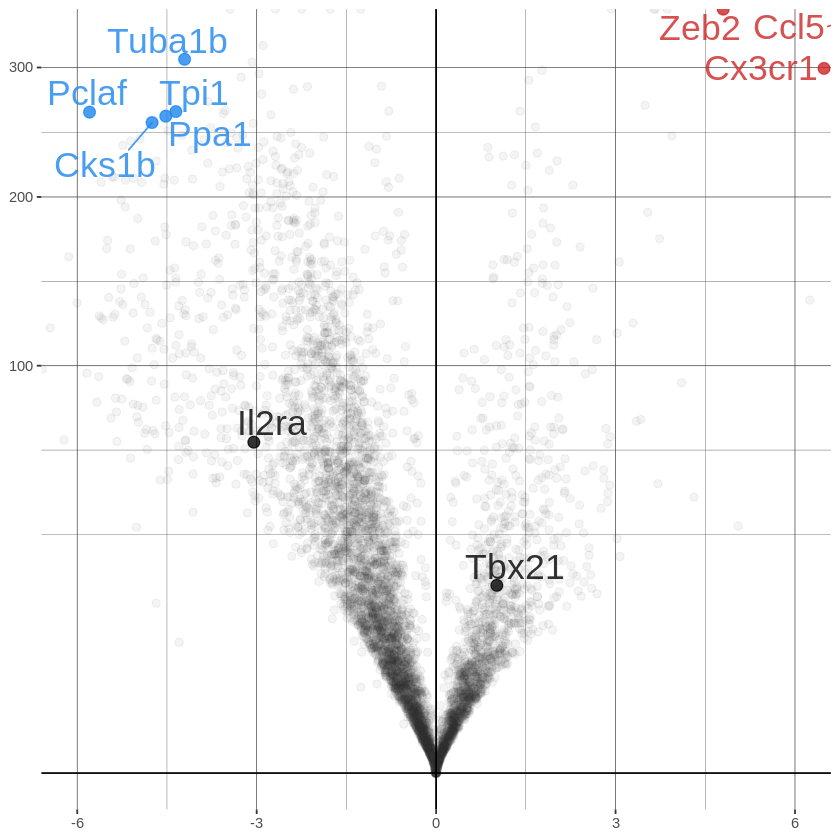

In [28]:
cp <- c("P10", "P2")
cp_oldnames <- cvt_names(cp, label.df$louvain_new_label, label.df$louvain)
cp_oldnames <- as.character(cp_oldnames)

###----- Setup
outname.base <- paste("All", cp[1], "vs", cp[2], sep="_")
use.genes <- c("Tbx21", "Il2ra", "Batf3")
log2fc.c <- 4
nlog10p.c <- 250

###----- Plot
# Read input
louvain.de.file <- paste(cp_oldnames[1], "vs", cp_oldnames[2], "differential.csv", sep="_")
louvain.de.file <- file.path(de.dir, file.path(cp_oldnames[1], louvain.de.file))
de.df <- read_csv(louvain.de.file)
# Filter out low expression & convert df for plotting
de.df <- de.df %>% 
  mutate(max_expr = pmax(pull(de.df, cp_oldnames[1]), pull(de.df, cp_oldnames[2]))) %>% filter(max_expr > 0.15) %>%
  drop_na() %>% select(one_of('gene_names', 't-test_logfc', 't-test_padj'))
colnames(de.df) <- c("gene_name", "log2fc", "padj")
de.df$nlog10pval <- -log10(de.df$padj)
# Plot
vol_plot <- volcano_plot(de.df, use.genes , log2fc.c, nlog10p.c) # With label
ggsave(paste(outname.base, ".png", sep=""), vol_plot, device='png', width=10, height=10, units='cm')
vol_plot
vol_plot <- vol_plot + theme(axis.text.x=element_blank(), axis.text.y=element_blank()) # Without label
ggsave(paste(outname.base, "_nolabel.png", sep=""), vol_plot, device='png', width=10, height=10, units='cm')

Parsed with column specification:
cols(
  gene_names = col_character(),
  `5` = col_double(),
  `6` = col_double(),
  wilcoxon_logfc = col_double(),
  wilcoxon_padj = col_double(),
  wilcoxon_score = col_double(),
  `t-test_logfc` = col_double(),
  `t-test_padj` = col_double(),
  `t-test_score` = col_double(),
  `t-test_overestim_var_logfc` = col_double(),
  `t-test_overestim_var_padj` = col_double(),
  `t-test_overestim_var_score` = col_double()
)

The following `from` values were not present in `x`: yes_FALSE_G1, yes_TRUE_G1, yes_TRUE_G2



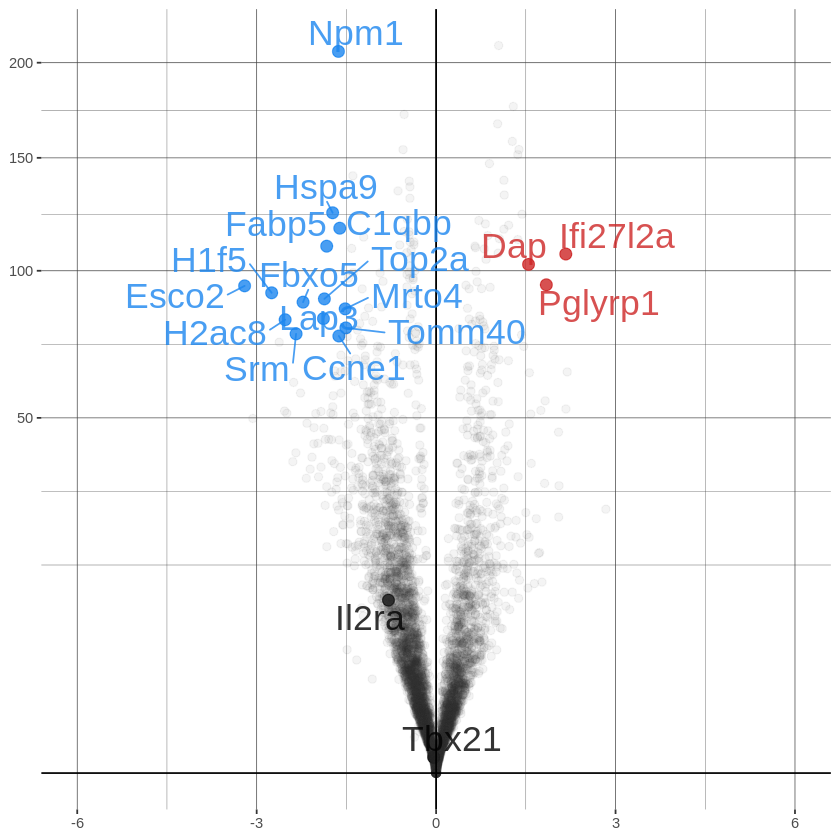

In [32]:
cp <- c("P6", "P2")
cp_oldnames <- cvt_names(cp, label.df$louvain_new_label, label.df$louvain)
cp_oldnames <- as.character(cp_oldnames)

###----- Setup
outname.base <- paste("All", cp[1], "vs", cp[2], sep="_")
use.genes <- c("Tbx21", "Il2ra", "Batf3")
log2fc.c <- 1.5
nlog10p.c <- 75

###----- Plot
# Read input
louvain.de.file <- paste(cp_oldnames[1], "vs", cp_oldnames[2], "differential.csv", sep="_")
louvain.de.file <- file.path(de.dir, file.path(cp_oldnames[1], louvain.de.file))
de.df <- read_csv(louvain.de.file)
# Filter out low expression & convert df for plotting
de.df <- de.df %>% 
  mutate(max_expr = pmax(pull(de.df, cp_oldnames[1]), pull(de.df, cp_oldnames[2]))) %>% filter(max_expr > 0.15) %>%
  drop_na() %>% select(one_of('gene_names', 't-test_logfc', 't-test_padj'))
colnames(de.df) <- c("gene_name", "log2fc", "padj")
de.df$nlog10pval <- -log10(de.df$padj)
# Plot
vol_plot <- volcano_plot(de.df, use.genes , log2fc.c, nlog10p.c) # With label
ggsave(paste(outname.base, ".png", sep=""), vol_plot, device='png', width=10, height=10, units='cm')
vol_plot
vol_plot <- vol_plot + theme(axis.text.x=element_blank(), axis.text.y=element_blank()) # Without label
ggsave(paste(outname.base, "_nolabel.png", sep=""), vol_plot, device='png', width=10, height=10, units='cm')

## 1. Arm / Cl13: cluster v.s. cluster

In [11]:
arm.de.dir <- '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/1_Scanpy/1_Scanpy_out_resampled_ARM-NAV/2_DE/Cluster_vs_Cluster'
cl13.de.dir <- '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/1_Scanpy/1_Scanpy_out_resampled_Cl13-NAV/2_DE/Cluster_vs_Cluster'

### P2 v.s. P0

In [64]:
cp <- c("P2", "P0")
cp_oldnames <- cvt_names(cp, label.df$louvain_new_label, label.df$louvain)
cp_oldnames <- as.character(cp_oldnames)

Parsed with column specification:
cols(
  gene_names = col_character(),
  `3` = col_double(),
  `6` = col_double(),
  wilcoxon_logfc = col_double(),
  wilcoxon_padj = col_double(),
  wilcoxon_score = col_double(),
  `t-test_logfc` = col_double(),
  `t-test_padj` = col_double(),
  `t-test_score` = col_double(),
  `t-test_overestim_var_logfc` = col_double(),
  `t-test_overestim_var_padj` = col_double(),
  `t-test_overestim_var_score` = col_double()
)

The following `from` values were not present in `x`: yes_FALSE_G2, yes_TRUE_G1, yes_TRUE_G2, no_TRUE_G2



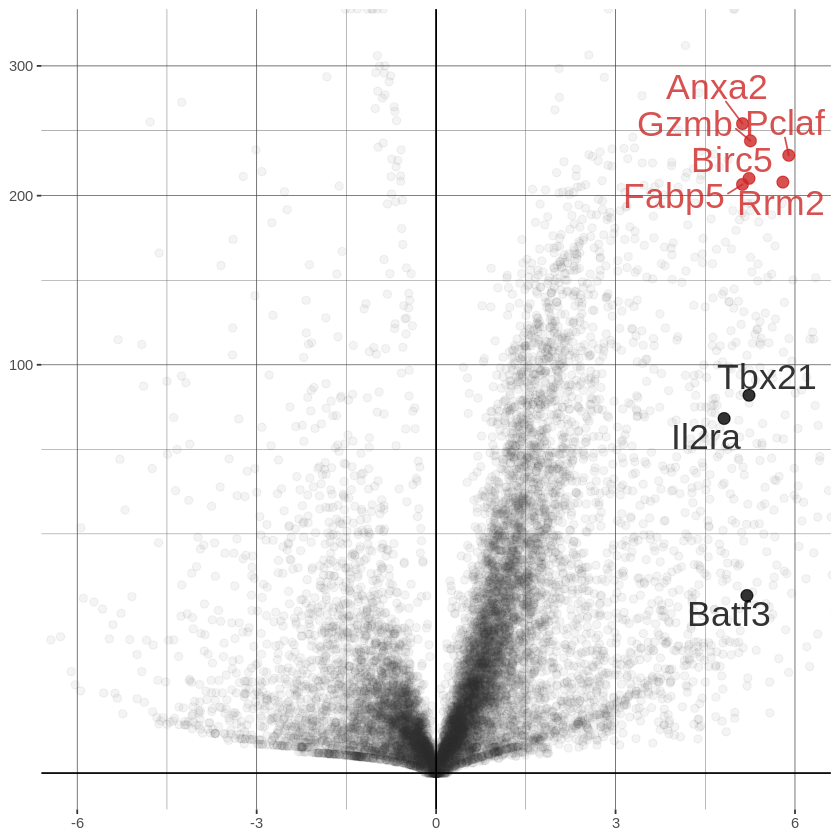

In [65]:
###----- Setup
de.dir <- arm.de.dir
outname.base <- paste("Arm", cp[1], "vs", cp[2], sep="_")
use.genes <- c("Tbx21", "Il2ra", "Batf3")
log2fc.c <- 5
nlog10p.c <- 200

###----- Plot
# Read input
louvain.de.file <- paste(cp_oldnames[1], "vs", cp_oldnames[2], "differential.csv", sep="_")
louvain.de.file <- file.path(de.dir, file.path(cp_oldnames[1], louvain.de.file))
de.df <- read_csv(louvain.de.file)
# Filter out low expression & convert df for plotting
de.df <- de.df %>% 
  mutate(max_expr = pmax(pull(de.df, cp_oldnames[1]), pull(de.df, cp_oldnames[2]))) %>% filter(max_expr > 0) %>%
  drop_na() %>% select(one_of('gene_names', 't-test_logfc', 't-test_padj'))
colnames(de.df) <- c("gene_name", "log2fc", "padj")
de.df$nlog10pval <- -log10(de.df$padj)
# Plot
vol_plot <- volcano_plot(de.df, use.genes , log2fc.c, nlog10p.c) # With label
ggsave(paste(outname.base, ".png", sep=""), vol_plot, device='png', width=10, height=10, units='cm')
vol_plot
vol_plot <- vol_plot + theme(axis.text.x=element_blank(), axis.text.y=element_blank()) # Without label
ggsave(paste(outname.base, "_nolabel.png", sep=""), vol_plot, device='png', width=10, height=10, units='cm')

Parsed with column specification:
cols(
  gene_names = col_character(),
  `3` = col_double(),
  `6` = col_double(),
  wilcoxon_logfc = col_double(),
  wilcoxon_padj = col_double(),
  wilcoxon_score = col_double(),
  `t-test_logfc` = col_double(),
  `t-test_padj` = col_double(),
  `t-test_score` = col_double(),
  `t-test_overestim_var_logfc` = col_double(),
  `t-test_overestim_var_padj` = col_double(),
  `t-test_overestim_var_score` = col_double()
)

The following `from` values were not present in `x`: yes_FALSE_G2, yes_TRUE_G1, yes_TRUE_G2



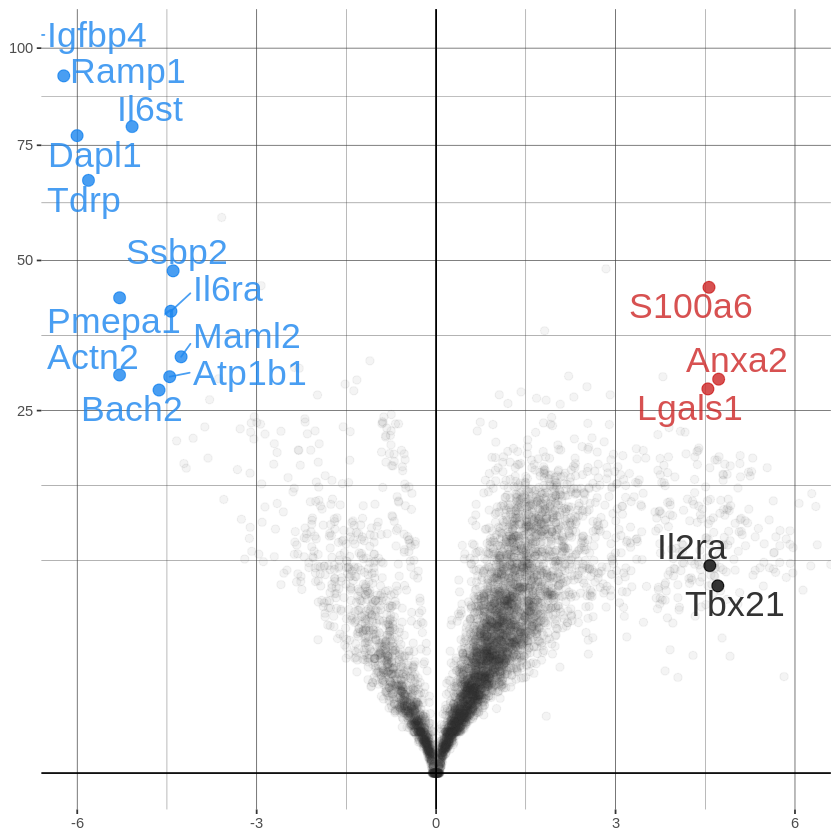

In [12]:
###----- Setup
de.dir <- cl13.de.dir
outname.base <- paste("Cl13", cp[1], "vs", cp[2], sep="_")
use.genes <- c("Tbx21", "Il2ra")
log2fc.c <- 4
nlog10p.c <- 25

###----- Plot
# Read input
louvain.de.file <- paste(cp_oldnames[1], "vs", cp_oldnames[2], "differential.csv", sep="_")
louvain.de.file <- file.path(de.dir, file.path(cp_oldnames[1], louvain.de.file))
de.df <- read_csv(louvain.de.file)
# Filter out low expression & convert df for plotting
de.df <- de.df %>% 
  mutate(max_expr = pmax(pull(de.df, cp_oldnames[1]), pull(de.df, cp_oldnames[2]))) %>% filter(max_expr > 0.15) %>%
  drop_na() %>% select(one_of('gene_names', 't-test_logfc', 't-test_padj'))
colnames(de.df) <- c("gene_name", "log2fc", "padj")
de.df$nlog10pval <- -log10(de.df$padj)
# Plot
vol_plot <- volcano_plot(de.df, use.genes , log2fc.c, nlog10p.c) # With label
ggsave(paste(outname.base, ".png", sep=""), vol_plot, device='png', width=10, height=10, units='cm')
vol_plot
vol_plot <- vol_plot + theme(axis.text.x=element_blank(), axis.text.y=element_blank()) # Without label
ggsave(paste(outname.base, "_nolabel.png", sep=""), vol_plot, device='png', width=10, height=10, units='cm')

## 2. In cluster: Arm v.s. Cl13

In [38]:
de.dir <- '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/1_Scanpy/0_Scanpy_out_resampled/2_DE/perCluster_Arm_vs_Cl13'

In [41]:
source(file.path(tool_dir, "pl_functions.R"))

In [53]:
"Bach2" %in% de.df$gene_name

[1] FALSE

Parsed with column specification:
cols(
  gene_names = col_character(),
  A = col_double(),
  C = col_double(),
  wilcoxon_logfc = col_double(),
  wilcoxon_padj = col_double(),
  wilcoxon_score = col_double(),
  `t-test_logfc` = col_double(),
  `t-test_padj` = col_double(),
  `t-test_score` = col_double(),
  `t-test_overestim_var_logfc` = col_double(),
  `t-test_overestim_var_padj` = col_double(),
  `t-test_overestim_var_score` = col_double()
)

The following `from` values were not present in `x`: yes_TRUE_G1, yes_TRUE_G2



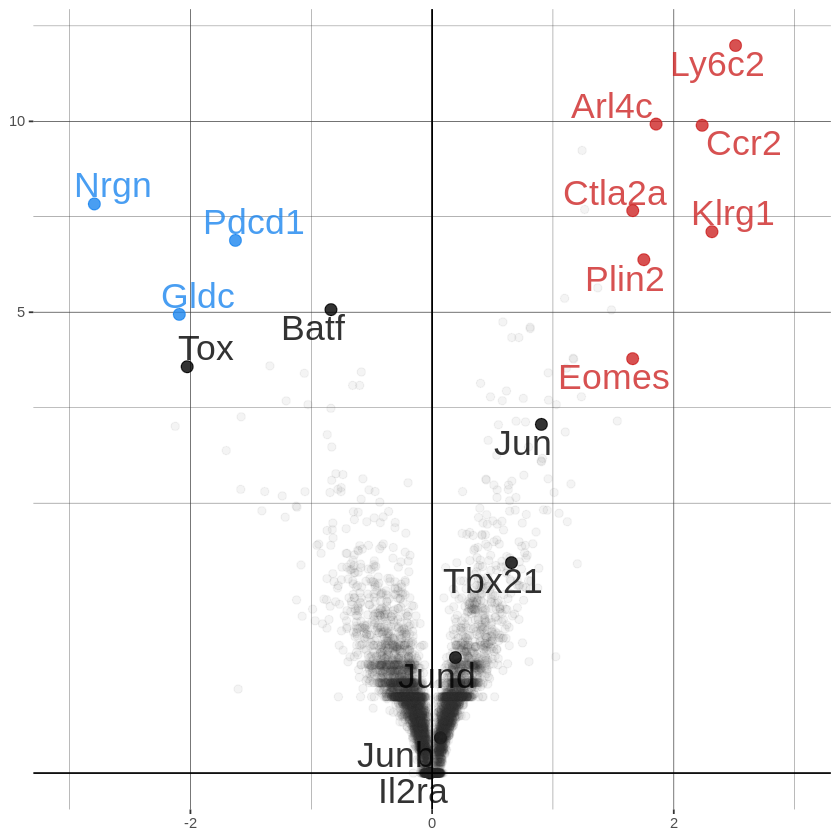

In [62]:
cluster <- c('P2')
cluster_oldname <- cvt_names(cluster, label.df$louvain_new_label, label.df$louvain)
cluster_oldname <- as.character(cluster_oldname)

cp_oldnames <- c("A", "C")

###----- Setup
outname.base <- paste(cluster, cp[1], "vs", cp[2], sep="_")
use.genes <- c("Tbx21", "Il2ra", "Batf", "Tox", "Bach2", "Jun", "Junb", "Jund", "Batf3")
log2fc.c <- 1.5
nlog10p.c <- 4

###----- Plot
# Read input
louvain.de.file <- paste(cp_oldnames[1], "vs", cp_oldnames[2], "differential.csv", sep="_")
louvain.de.file <- file.path(de.dir, cluster_oldname,file.path(cp_oldnames[1], louvain.de.file))
de.df <- read_csv(louvain.de.file)
# Filter out low expression & convert df for plotting
de.df <- de.df %>% 
  mutate(max_expr = pmax(pull(de.df, cp_oldnames[1]), pull(de.df, cp_oldnames[2]))) %>% filter(max_expr > 0.15) %>% 
  drop_na() %>% select(one_of('gene_names', 't-test_logfc', 't-test_padj'))
colnames(de.df) <- c("gene_name", "log2fc", "padj")
de.df$nlog10pval <- -log10(de.df$padj)
# Plot
vol_plot <- volcano_plot(de.df, use.genes , log2fc.c, nlog10p.c, c(-3,3)) # With label
ggsave(paste(outname.base, ".png", sep=""), vol_plot, device='png', width=10, height=10, units='cm')
vol_plot
vol_plot <- vol_plot + theme(axis.text.x=element_blank(), axis.text.y=element_blank()) # Without label
ggsave(paste(outname.base, "_nolabel.png", sep=""), vol_plot, device='png', width=10, height=10, units='cm')